In [22]:
# select the data
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../../')

import numpy as np
from third_party.colmap.scripts.python.read_write_model import read_model, qvec2rotmat
from third_party.colmap.scripts.python.read_dense import read_array
from imageio import imread
import matplotlib.pyplot as plt
import h5py
from time import time
from glob import glob
import cv2

root = '../../../data'
dataset = 'phototourism'
scene = 'british_museum'
# dataset = 'ggl'
# scene = 'sydney_2'
ext = 'jpg' if dataset == 'phototourism' else 'png'
dataset_folder = '{}/{}/{}/set_100'.format(root, dataset, scene)
src = root + '/' + scene
print(f'Done')

all_names = [f.split('/')[-1].split('.')[0] for f in glob('{}/{}/{}/set_100/images/*.{}'.format(root, dataset, scene, ext))]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


In [24]:
# Retrieve one image, the depth map, and 2D points
def load_image(name):
    image = imread('{}/images/{}.{}'.format(dataset_folder, name, ext))
    try:
        with h5py.File('{}/depth_maps/{}.h5'.format(dataset_folder, name)) as f:
            depth = f['depth'].value
    except:
        depth = None
        print('Failed to load depth maps.')
    with h5py.File('{}/calibration/calibration_{}.h5'.format(dataset_folder, name)) as f:
        K = f['K'].value
#         v = K[0, 2]; K[0, 2] = K [1, 2]; K[1, 2] = v;
        R = f['R'].value
        T = f['T'].value
    return image, depth, K, R, T


def map_r_to_xy(r, x=None, y=None):
    if x is None and y is None:
        raise RuntimeError('Must specify x or y.')
    if x is not None and y is not None:
        raise RuntimeError('Cannot specify both x and y.')
    if x is not None:
        return -(r[0] * x + r[2]) / r[1]
    return -(r[1] * y + r[2]) / r[0]


def get_epipolar_lines_for_plotting(cv2_epiline, width, height):
    points = []
    x = 0
    y = map_r_to_xy(cv2_epiline, x=x)
    if y >= 0 and y < height:
        points += [(x, y)]

    y = 0
    x = map_r_to_xy(cv2_epiline, y=y)
    if x >= 0 and x < width:
        points += [(x, y)]
    if len(points) == 2:
        return points

    x = width - 1
    y = map_r_to_xy(cv2_epiline, x=x)
    if y >= 0 and y < height:
        points += [(x, y)]
    if len(points) == 2:
        return points
        
    y = height - 1
    x = map_r_to_xy(cv2_epiline, y=y)
    if x >= 0 and x < width:
        points += [(x, y)]
    if len(points) == 2:
        return points
    else:
        raise RuntimeError('Should not be here.')

0 257.6278097298233 1040 177.3842227929126
0 193.50111039863057 1052 178.48608678414308


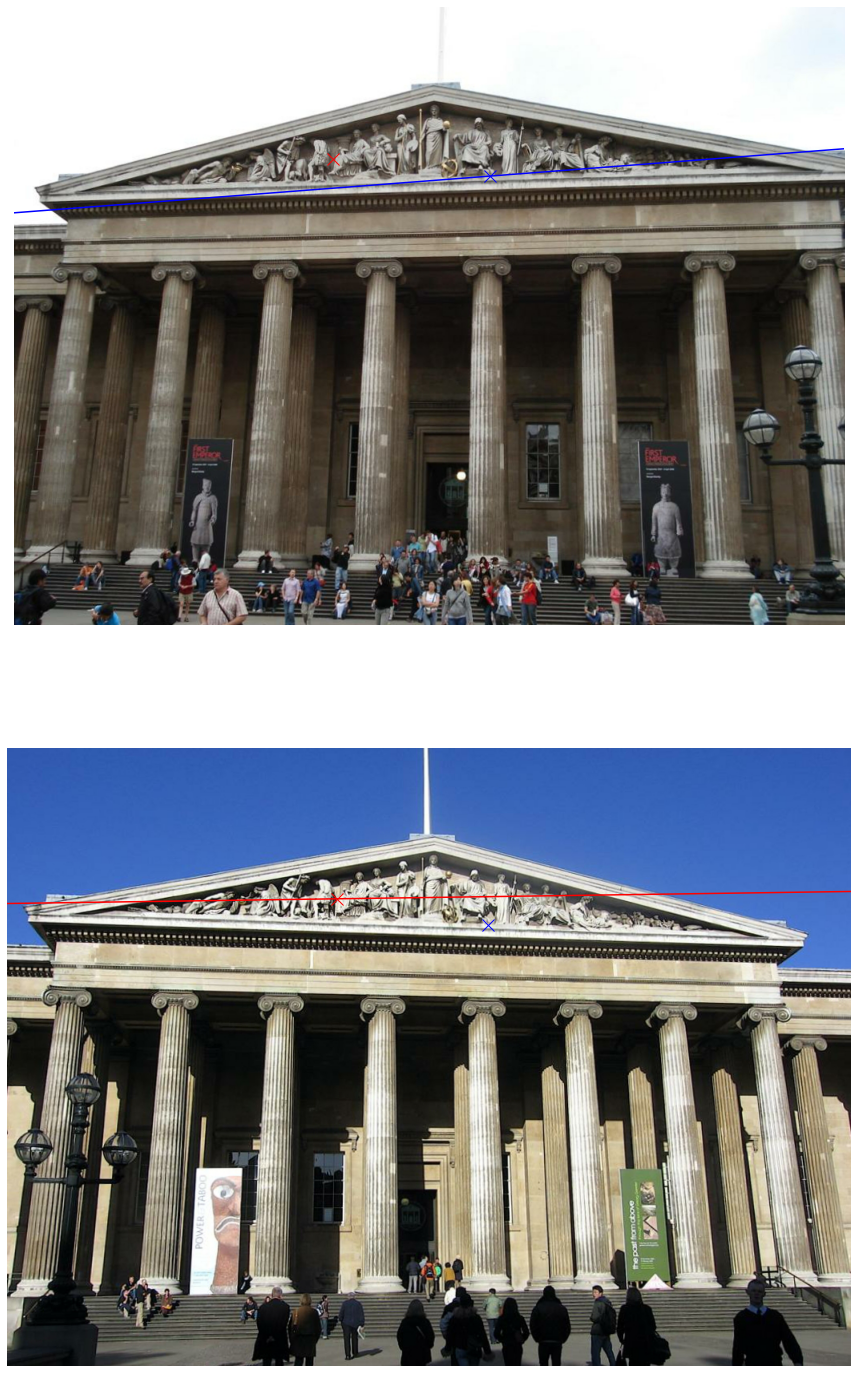

In [27]:
from utils.stereo_helper import (np_skew_symmetric, get_projected_kp,
                                 normalize_keypoints, unnormalize_keypoints,
                                 get_truesym)

draw_epipolar_lines = True

image1, depth1, K1, R1, T1 = load_image(all_names[0])
image2, depth2, K2, R2, T2 = load_image(all_names[1])
has_depth = depth1 is not None and depth2 is not None

T1 = T1[..., None]
T2 = T2[..., None]
dR = np.dot(R2, R1.T)
dT = T2 - np.dot(dR, T1)
E = np.matmul(
        np.reshape(np_skew_symmetric(dT[None, ...]), (-1, 3, 3)),
        dR[None, ...])[0]
F = np.matmul(np.linalg.inv(K2.T), np.matmul(E, np.linalg.inv(K1)))

# (x, y)
p1 = np.array([[400, 190]])
p2 = np.array([[600, 220]])
# p2 = np.array([[400, 320]])

if has_depth:
    depth_p1 = np.array([[depth1[int(p[1]), int(p[0])] for p in p1]])
    depth_p2 = np.array([[depth2[int(p[1]), int(p[0])] for p in p2]])
    assert all(depth_p1 > 0)
    assert all(depth_p2 > 0)

    # Project with depth.
    p1n = normalize_keypoints(p1, K1)
    p2n = normalize_keypoints(p2, K2)
    p1n_p, p2n_p = get_projected_kp(p1n, p2n, depth_p1, depth_p2, dR, dT)
    p1_p = unnormalize_keypoints(p1n_p, K2)
    p2_p = unnormalize_keypoints(p2n_p, K1)

ms = 12
fig = plt.figure(figsize=(25, 25))
fig.add_subplot(2, 1, 1)
plt.imshow(image1)
plt.plot(p1[:, 0], p1[:, 1], 'rx', markersize=ms)
if has_depth:
    plt.plot(p2_p[:, 0], p2_p[:, 1], 'bx', markersize=ms)
if draw_epipolar_lines:
    epi1 = cv2.computeCorrespondEpilines(p2[None, ...], 2, F)[0][0]
    (x0, y0), (x1, y1) = get_epipolar_lines_for_plotting(epi1, width=image1.shape[1], height=image1.shape[0])
    print(x0, y0, x1, y1)
    plt.plot((x0, x1), (y0, y1), 'b-')
plt.axis('off')

fig.add_subplot(2, 1, 2)
plt.imshow(image2)
plt.plot(p2[:, 0], p2[:, 1], 'bx', markersize=ms)
if has_depth:
    plt.plot(p1_p[:, 0], p1_p[:, 1], 'rx', markersize=ms)
if draw_epipolar_lines:
    epi2 = cv2.computeCorrespondEpilines(p1[None, ...], 1, F)[0][0]
    (x0, y0), (x1, y1) = get_epipolar_lines_for_plotting(epi2, width=image2.shape[1], height=image2.shape[0])
    print(x0, y0, x1, y1)
    plt.plot((x0, x1), (y0, y1), 'r-')
plt.axis('off')
plt.show()

In [ ]:
# Project with depth (by hand, instead of using benchmark calls)

# (x, y, z)
xyz1, xyz2 = [], []
for (x, y), z in zip(normalize_keypoints(p1, K1), depth_p1):
    xyz1 += [x * z[0], y * z[0], z[0]]
for (x, y), z in zip(normalize_keypoints(p2, K2), depth_p2):
    xyz2 += [x * z[0], y * z[0], z[0]]
xyz1 = np.array(xyz1)
xyz2 = np.array(xyz2)

# xyz1_cam2 = np.matmul(R2, xyz1.T)[..., None] + T2
xyz1_cam2, xyz2_cam1 = get_projected_kp(p1n, p2n, depth_p1, depth_p2, dR, dT)

# cam_landmark = np.matmul(cam_r_ll, landmarks.T) + cam_p_ll[..., None]
xyz1_cam2 = xyz1_cam2[:2] / xyz1_cam2[-1, :]
xyz1_cam2 = unnormalize_keypoints(xyz1_cam2.squeeze(), K2)

print(p1)
print(p1_p)
print(xyz1_cam2)

In [195]:
normalize_keypoints(p1, K1)

array([[-0.10318815, -0.16869764]])

In [226]:
print(K1)
print(K2)

[[1.16776978e+03 0.00000000e+00 5.20500000e+02]
 [0.00000000e+00 1.16776978e+03 3.87000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[1.05975513e+03 0.00000000e+00 5.26500000e+02]
 [0.00000000e+00 1.05975513e+03 3.85500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [229]:
print(K1)
print(K2)

[[674.5027383    0.         427.01690237]
 [  0.         673.91332869 239.82048499]
 [  0.           0.           1.        ]]
[[674.5027383    0.         427.01690237]
 [  0.         673.91332869 239.82048499]
 [  0.           0.           1.        ]]
